# Chance of winning a biathlon race

Biathlon is an exciting winter sport as the shooting introduces an element of chance to the result list. On a lucky day even an underdog has a to reach the podium. With this analysis we explore who the favorites are in the upcoming world championships in Östersund.

The final result can be broken down to the following components:

- `Ski time`: The time between the shootings.
- `Range time`: The time from start to end of each shooting.
- `Penalty time`: Every missed target is penalized with a fixed minute in long, individual races and with a penalty loop of about 150 meters in other races. 

In our model we compute each component based on data gathered from the [IBU Data Center](https://biathlonresults.com/) from the 2018/2019 season. Only runners that have taken part in at least five races are included. Pursuits and relays are also left out.

Each component is modeled like this:

- `Ski_time`: How many percent slower/faster is each runner compared than the mean of the fastest 30 runners in each race? The ski time is calculated based on the mean and standard deviation of this measure.
- `Range time`: How many seconds to each runner, on average, require on the shooting range. Standard deviation also taken into account.
- `Penalty time`: What is the likelihood of hitting a target for each runner? The penalty time is modeled as a binomial distribution multiplied by the average time of a penalty lap for each runner.



In [1]:
# Set working dir to project root",
import os
os.chdir('..')

In [2]:
%matplotlib inline

import pandas as pd
from glob import glob
import os
import numpy as np
import seaborn as sns
import urllib
import matplotlib as mpl

import matplotlib.pyplot as plt
from modules.ibu_utils import *

DF_IMPORT_DIR = "data/dataframes"


In [21]:
# The data frame is prepared in another notebook
file_path = os.path.join(DF_IMPORT_DIR, "by_race_and_runner - prepared.csv")
df = pd.read_csv(file_path, encoding="utf-8")

# Parse timedeltas
time_cols = [u'ski_time', u'range_time', u'final_time_abs', u'penalty_time', u'ski_and_range_time', u'final_time_without_penalty', u'winner_time', u'podium_time', u'ski_time_vs_mean', u'range_time_vs_mean', u'penalty_time_vs_mean', u'ski_and_range_time_vs_mean', u'final_time_abs_vs_mean']
df[time_cols] = df[time_cols].apply(pd.to_timedelta)

# We ignore pursuits here 
df = df[df["discipline"] != "Pursuit"]
df = df.drop(columns="Unnamed: 0")
# Hack: some dups slipped through in the scraper
df = df.drop_duplicates()
df.head()

season           event                    race    sex           name  \
0  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women  K. INNERHOFER   
1  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women     S. DUNKLEE   
2  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women      D. WIERER   
3  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women     L. PERSSON   
4  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women       J. SIMON   

   nat        ski_time      range_time  misses  final_time_abs  \
0  aut 00:39:05.700000 00:03:15.300000     4.0 00:46:47.100000   
1  usa 00:39:28.900000 00:03:12.500000     1.0 00:44:07.500000   
2  ita 00:38:30.900000 00:02:43.900000     2.0        00:43:40   
3  swe 00:39:38.900000 00:03:31.200000     1.0 00:44:35.800000   
4  fra 00:39:18.200000 00:02:43.900000     3.0 00:45:27.800000   

          ...         penalty_time_vs_mean_std ski_and_range_time_vs_mean  \
0         ...                         2.484274   -1 days +23:59:53.933333   
1         ...                        -0.415594            00:00:14.333333   
2         ...                         0.536529   -1 days +23:58:47.733333   
3         ...                        -0.422038            00:00:43.033333   
4         ...                         1.511207   -1 days +23:59:35.033333   

  ski_and_range_time_vs_mean_pct ski_and_range_time_vs_mean_std  \
0                      -0.002382                      -0.121649   
1                       0.005627                       0.287413   
2                      -0.028373                      -1.449096   
3                       0.016895                       0.862907   
4                      -0.009802                      -0.500633   

    final_time_abs_vs_mean  final_time_abs_vs_mean_pct  \
0          00:02:28.136666                    0.055712   
1 -1 days +23:59:48.536666                   -0.004311   
2 -1 days +23:59:21.036666                   -0.014654   
3          00:00:16.836666                    0.006332   
4          00:01:08.836666                    0.025889   

   final_time_abs_vs_mean_std misses_vs_mean misses_vs_mean_pct  \
0                    3.819757       2.566667           1.790698   
1                   -0.295586      -0.433333          -0.302326   
2                   -1.004683       0.566667           0.395349   
3                    0.434139      -0.433333          -0.302326   
4                    1.774978       1.566667           1.093023   

   misses_vs_mean_std  
0            2.467938  
1           -0.416665  
2            0.544869  
3           -0.416665  
4            1.506404  

[5 rows x 59 columns]

In [22]:
# These are our columns
df.dtypes

season                                     object
event                                      object
race                                       object
sex                                        object
name                                       object
nat                                        object
ski_time                          timedelta64[ns]
range_time                        timedelta64[ns]
misses                                    float64
final_time_abs                    timedelta64[ns]
date                                       object
runner                                     object
race_key                                   object
discipline                                 object
n_shootings                                 int64
n_shots                                     int64
shot_pct                                  float64
penalty_time                      timedelta64[ns]
ski_and_range_time                timedelta64[ns]
avg_penalty_time                          float64


In [23]:
# There is some missing data from Solider Hollow (missing @ IBU Data center at time of scraping)
df.groupby(["event", "sex"]).size()

event                       sex  
Antholz-Anterselva (ITA)    men      138
                            women    141
Canmore (CAN)               men       98
                            women     93
Hochfilzen (AUT)            men      110
                            women    116
Nove Mesto (CZE)            men      137
                            women    150
Oberhof (GER)               men      108
                            women    114
Pokljuka (SLO)              men      220
                            women    205
Ruhpolding (GER)            men      141
                            women    148
Soldier Hollow, Utah (USA)  men       87
                            women     86
dtype: int64

## Race simulations

In this analysis we will create a model for predicting results, viden 

In [28]:
def make_race_simulations(df, race, n_race_threshold=5, n_simulations=10000):
    """
    :param df: input data, expecting each row to represent a single runner in a race. 
    :param race: eg "Women 7.5 km Sprint" or "Men 20 km Individual" 
    :param n_race_threshold: Only include runners that have taken part in this many races.
    """
    assert race in df.race.unique(), df.race.unique()
    print u"Simulating {} {} races".format(n_simulations, race)

    sex = race.split(" ")[0].lower()

    def get_discipline(race):
        # "Women 7.5 km Sprint" => "Sprint"
        return race.split("km ")[-1].replace("Short Individual", "Individual")

    discipline = get_discipline(race)
    
    if discipline == "Sprint":
        n_shootings = 2
    else:
        n_shootings = 4
    
    # Aggregate a data frame where each row represents a runner
    by_runner = df[(df["sex"] == sex) & df["misses"].notna()].groupby("runner")
    _df = pd.concat([
        # The shot percent is calculated as the total number of missed target divided by the total number of shots
       (1 - (by_runner["misses"].sum() / by_runner["n_shots"].sum() )).rename("shot_pct"),
        
        # ski_time_vs_mean_pct = percentual diff from the mean of the fastast 30 skiers
       by_runner["ski_time_vs_mean_pct"].mean().rename("ski_time_mean"), 
       by_runner["ski_time_vs_mean_pct"].std().rename("ski_time_std"), 
       by_runner.apply(lambda x: (x["range_time"].dt.seconds / x["n_shootings"]).mean()).rename("range_time_mean"), 
       by_runner.apply(lambda x: (x["range_time"].dt.seconds / x["n_shootings"]).std()).rename("range_time_std"), 

        by_runner["name"].count().rename("n_races"),
       df[df["discipline"] != "Individual"].groupby("runner")["avg_penalty_time"].mean().sort_values() 
    ], axis=1, sort=False)
    _df = _df[_df["n_races"] >= n_race_threshold]

    # We assume that the race time will be the mean of this kind of race 
    race_times = df[df.is_top_30].groupby("race")["final_time_abs"].apply(lambda x: x.dt.seconds.mean())
    race_time = race_times.loc[race]


    def simulate_ski_time(row):
        # The ski time is assumed to follow normal distribution
        # We simulate the difference from mean, and the multiply by the avg race time
        vs_mean = np.random.normal(row["ski_time_mean"], row["ski_time_std"], n_simulations) + 1
        return vs_mean * race_time

    def simulate_range_time(row):
        # The range time is assumed to follow normal distribution        
        return np.random.normal(row["range_time_mean"], row["range_time_std"], n_simulations) * n_shootings

    def simulate_penalty_time(row):
        # 1. calculate expected number of hits
        n_hits = np.random.binomial(n_shootings * 5, row["shot_pct"], n_simulations)
        
        # 2. caluculate number of missed targets and subsequent penalty time
        n_misses = n_shootings * 5 - n_hits
        if "Short Individual" in race:
            penalty_time = 45
        elif "Individual" in race:
            penalty_time = 60
        else:
            # Assume the time it takes to do a penalty lap to be the same as the historical average of the runner
            # In reality the penalty time would vary with the conditions and the arena
            penalty_time = row["avg_penalty_time"]
        return n_misses * penalty_time

    # Make simulations for each result component
    ski_time_sims = _df.apply(simulate_ski_time, axis=1)
    range_time_sims = _df.apply(simulate_range_time, axis=1)
    penalty_time_sims = _df.apply(simulate_penalty_time, axis=1)
    
    # ...and put it all together
    total_time_sims = ski_time_sims + range_time_sims + penalty_time_sims
    
    # reshape frame
    simulations = pd.DataFrame(np.stack(total_time_sims, axis=0), index=_df.index)
    
    return simulations, (ski_time_sims, range_time_sims, penalty_time_sims)


RACE = "Women 7.5 km Sprint"
sims, (ski_sims, range_sims, penalty_sims) = make_race_simulations(df, RACE)

sims.head()


Simulating 10000 Women 7.5 km Sprint races


0            1            2            3     \
A. BESCOND (fra)    1407.297224  1453.402035  1411.161093  1401.221716   
A. CHEVALIER (fra)  1423.503332  1465.562269  1478.056496  1396.701846   
A. FROLINA (kor)    1496.800394  1452.043412  1471.950557  1482.290246   
A. GASPARIN (sui)   1542.553764  1525.854966  1573.923798  1581.506191   
A. GHILENKO (mda)   1529.409742  1540.298319  1626.711242  1528.442585   

                           4            5            6            7     \
A. BESCOND (fra)    1462.205365  1473.225268  1412.703438  1378.922821   
A. CHEVALIER (fra)  1361.091786  1408.837493  1442.890762  1427.418901   
A. FROLINA (kor)    1500.376346  1459.033702  1447.397359  1452.979000   
A. GASPARIN (sui)   1508.537902  1487.024498  1535.811180  1517.791771   
A. GHILENKO (mda)   1564.410652  1506.535548  1567.755738  1557.952006   

                           8            9        ...              9990  \
A. BESCOND (fra)    1383.039552  1444.737469     ...       1406.561024   
A. CHEVALIER (fra)  1422.162510  1381.057850     ...       1412.294385   
A. FROLINA (kor)    1408.459570  1423.464082     ...       1512.498243   
A. GASPARIN (sui)   1549.570055  1543.253352     ...       1564.240933   
A. GHILENKO (mda)   1654.412466  1495.195317     ...       1636.535884   

                           9991         9992         9993         9994  \
A. BESCOND (fra)    1481.128136  1428.582085  1429.217406  1390.748587   
A. CHEVALIER (fra)  1435.920495  1389.865131  1378.488952  1422.142305   
A. FROLINA (kor)    1551.080816  1486.026471  1442.480113  1423.709616   
A. GASPARIN (sui)   1542.543928  1596.394934  1463.409775  1490.853152   
A. GHILENKO (mda)   1553.546860  1595.707013  1652.249412  1541.414354   

                           9995         9996         9997         9998  \
A. BESCOND (fra)    1439.208667  1366.262341  1485.499003  1448.809223   
A. CHEVALIER (fra)  1415.836345  1408.437690  1446.118743  1516.474549   
A. FROLINA (kor)    1514.563214  1477.249817  1462.554744  1457.286304   
A. GASPARIN (sui)   1539.687092  1409.652330  1513.656823  1492.662737   
A. GHILENKO (mda)   1583.989358  1591.771067  1543.382236  1553.014262   

                           9999  
A. BESCOND (fra)    1417.054195  
A. CHEVALIER (fra)  1418.640506  
A. FROLINA (kor)    1455.247629  
A. GASPARIN (sui)   1496.814691  
A. GHILENKO (mda)   1599.311115  

[5 rows x 10000 columns]

### Comparing two runners

Let's illustrate the model by comparing two runners, Hanna Öberg from Sweden and Kaisa Mäkäräinen from Finland. First we'll have a look at the predicted **ski time**.

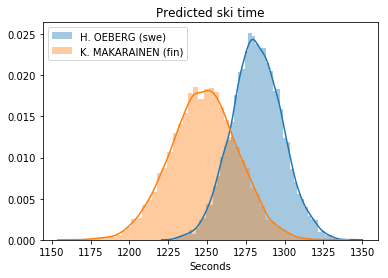

In [44]:
EXAMPLE_RUNNERS = ["H. OEBERG (swe)", "K. MAKARAINEN (fin)"]

for runner in EXAMPLE_RUNNERS:
    sns.distplot(ski_sims.loc[runner]).set(xlabel="Seconds", label=runner, title="Predicted ski time");
plt.legend(EXAMPLE_RUNNERS, loc="best")
plt.show()

Mäkäräinen is clearly a better skier and expected to outperform Öberg by about 30 seconds on the course.

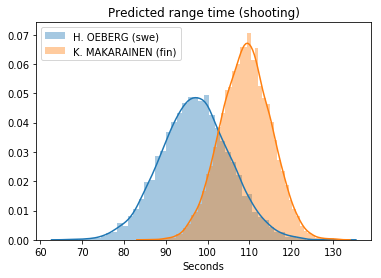

In [46]:
for runner in EXAMPLE_RUNNERS:
    sns.distplot(range_sims.loc[runner]).set(xlabel="Seconds", label=runner, title="Predicted range time (shooting)");
plt.legend(EXAMPLE_RUNNERS, loc="best")
plt.show()

Öberg, however, is a faster shooter and expected to gain about 15 seconds on the shooting range. 

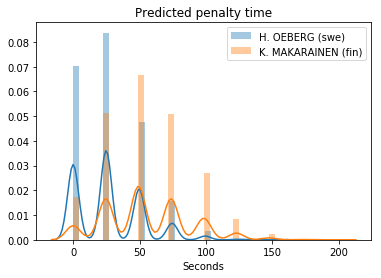

In [47]:
for runner in EXAMPLE_RUNNERS:
    sns.distplot(penalty_sims.loc[runner]).set(xlabel="Seconds", label=runner, title="Predicted penalty time");
plt.legend(EXAMPLE_RUNNERS, loc="best")
plt.show()

Lastly we model the expected penalty time based on the historical shoting accuracy of each runner. Öberg hits her targets about 89 percent of the time, Mäkäräinen only 80 percent. This means Öberg is likely to get away with one or even zero misses, while Mäkärinen it is not uncommon that Mäkäräinen gets to two penalty runs, costing her about 50 seconds. 

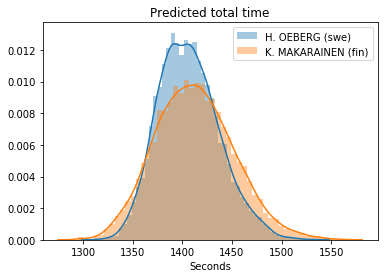

In [48]:
for runner in EXAMPLE_RUNNERS:
    sns.distplot(sims.loc[runner]).set(xlabel="Seconds", label=runner, title="Predicted total time");
plt.legend(EXAMPLE_RUNNERS, loc="best")
plt.show()

In [60]:
s1 = sims.loc[EXAMPLE_RUNNERS[0]]
s2 = sims.loc[EXAMPLE_RUNNERS[1]]
r1_wins = (s1 < s2).sum()
n_total = s1.count()
"{runner1} beats {runner2} in {r1_wins} out of {n_total} races ({pct} percent) ".format(
    runner1 = EXAMPLE_RUNNERS[0],
    runner2 = EXAMPLE_RUNNERS[1],
    r1_wins = r1_wins,
    n_total = n_total,
    pct = ((r1_wins / float(n_total)) * 100).round()) 

'H. OEBERG (swe) beats K. MAKARAINEN (fin) in 5464 out of 10000 races (55.0 percent) '

If we but all of this together we see that Öbergs performance at the range is likely to outweight Mäkäräinens ski performance. On the other Mäkäräinen has a higher capacity and better chance of reaching times below 1350 seconds (22 minutes).

### Chance of winning

To be calculate the chance of winning (or reaching the podium) we need to compute ranks for all the simulated results.

In [70]:
rank_df = sims.rank()
rank_df.head()

0     1     2     3     4     5     6     7      8     \
A. BESCOND (fra)    11.0  35.0  14.0  10.0  39.0  44.0  14.0   4.0   10.0   
A. CHEVALIER (fra)  18.0  44.0  54.0   7.0   4.0  12.0  29.0  29.0   24.0   
A. FROLINA (kor)    61.0  34.0  49.0  51.0  59.0  39.0  31.0  38.0   16.0   
A. GASPARIN (sui)   80.0  77.0  87.0  94.0  64.0  56.0  84.0  69.0   85.0   
A. GHILENKO (mda)   75.0  83.0  97.0  77.0  91.0  68.0  89.0  86.0  101.0   

                    9     ...   9990  9991  9992  9993  9994  9995  9996  \
A. BESCOND (fra)    37.0  ...   13.0  55.0  25.0  26.0   4.0  33.0   4.0   
A. CHEVALIER (fra)   3.0  ...   15.0  26.0   6.0   4.0  21.0  17.0  19.0   
A. FROLINA (kor)    22.0  ...   68.0  88.0  52.0  33.0  22.0  71.0  54.0   
A. GASPARIN (sui)   84.0  ...   87.0  83.0  95.0  49.0  53.0  80.0  20.0   
A. GHILENKO (mda)   66.0  ...   98.0  90.0  94.0  99.0  82.0  92.0  94.0   

                    9997  9998  9999  
A. BESCOND (fra)    55.0  35.0  18.0  
A. CHEVALIER (fra)  30.0  75.0  20.0  
A. FROLINA (kor)    42.0  40.0  44.0  
A. GASPARIN (sui)   67.0  61.0  65.0  
A. GHILENKO (mda)   83.0  90.0  97.0  

[5 rows x 10000 columns]

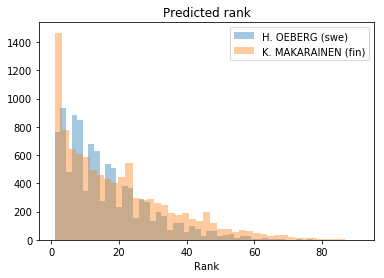

H. OEBERG (swe) is a winner in 319/10000 races, K. MAKARAINEN (fin) in 592/10000 races.


In [71]:
for runner in EXAMPLE_RUNNERS:
    sns.distplot(rank_df.loc[runner], kde=False).set(xlabel="Rank", label=runner, title="Predicted rank")
plt.legend(EXAMPLE_RUNNERS, loc="best")
plt.show()

n_wins1 = (rank_df.loc[EXAMPLE_RUNNERS[0]] == 1).sum()
n_wins2 = (rank_df.loc[EXAMPLE_RUNNERS[1]] == 1).sum()
n_races = rank_df.shape[1]
print "{runner1} is a winner in {n_wins1}/{n_races} races, {runner2} in {n_wins2}/{n_races} races.".format(
    runner1=EXAMPLE_RUNNERS[0],
    runner2=EXAMPLE_RUNNERS[1],
    n_wins1=n_wins1,
    n_wins2=n_wins2,
    n_races=n_races,
)

So, while Hanna Öberg is expected to beat Kaisa Mäkäräinen more often than not, Mäkäräinen is twice as likely to win the race.

## All together: Who will win each race?

No let's apply this model to the whole field. How is likely to win medals in each race?

In [73]:
def get_podium_probabilities(simulations):
    """Aggregate probablities of winning and podium for each runner, based on simulated final times."""
    simulations_ranks = simulations.rank()
    n_simulations = simulations.shape[1]

    prob_podium = simulations_ranks[simulations_ranks<=3].count(axis=1) / float(n_simulations)
    prob_win = simulations_ranks[simulations_ranks==1].count(axis=1) / float(n_simulations)
        
    return pd.concat([
      prob_win.rename("prob_win"),
      prob_podium.rename("prob_podium"),
    ], axis=1, sort=False)

races = ["Women 7.5 km Sprint", "Women 12.5 km Mass Start", "Women 15 km Individual",
         "Men 10 km Sprint", "Men 15 km Mass Start", "Men 20 km Individual"]

podium_prob_dfs = []
for race in races:
    sims, _ = make_race_simulations(df, race)
    race_podium_probs = get_podium_probabilities(sims)
    race_podium_probs["race"] = race
    podium_prob_dfs.append(race_podium_probs)
    
podium_probs = pd.concat(podium_prob_dfs, sort=False)
podium_probs.head()

Simulating 10000 Women 7.5 km Sprint races
Simulating 10000 Women 12.5 km Mass Start races
Simulating 10000 Women 15 km Individual races
Simulating 10000 Men 10 km Sprint races
Simulating 10000 Men 15 km Mass Start races
Simulating 10000 Men 20 km Individual races


prob_win  prob_podium                 race
A. BESCOND (fra)      0.0141       0.0633  Women 7.5 km Sprint
A. CHEVALIER (fra)    0.0518       0.1201  Women 7.5 km Sprint
A. FROLINA (kor)      0.0000       0.0008  Women 7.5 km Sprint
A. GASPARIN (sui)     0.0000       0.0000  Women 7.5 km Sprint
A. GHILENKO (mda)     0.0000       0.0000  Women 7.5 km Sprint

In [82]:
for race, _df in podium_probs.groupby("race"):
    heading = "Most likely winners in {}".format(race)
    print "\n\n{}".format(heading)
    print "=" * len(heading)
    print _df[["prob_win", "prob_podium"]].sort_values("prob_win", ascending=False).head(10).multiply(100).round(1).rename(columns={"prob_win": "Chance to win", "prob_podium": "Chance for medal"})





Most likely winners in Men 10 km Sprint
                         Chance to win  Chance for medal
J.T. BOE (nor)                    58.3              82.0
B. DOLL (ger)                      4.7              16.0
S. DESTHIEUX (fra)                 4.6              22.1
A. LOGINOV (rus)                   4.3              19.8
M. FOURCADE (fra)                  4.3              23.5
Q. FILLON MAILLET (fra)            2.9              14.5
V.S. CHRISTIANSEN (nor)            2.5               9.6
A. PEIFFER (ger)                   2.3              13.4
J. EBERHARD (aut)                  2.0              11.5
M. ELISEEV (rus)                   1.3               4.0


Most likely winners in Men 15 km Mass Start
                         Chance to win  Chance for medal
J.T. BOE (nor)                    62.0              86.1
M. FOURCADE (fra)                  4.8              25.8
S. DESTHIEUX (fra)                 4.1              22.0
A. LOGINOV (rus)                   3.9              18.7


There you have it. Now place your bets!

A few notes:

- Strong skiers such as Kaisa Mäkäräinen are expected to perform best in sprints, while a good shooter as Hanna Öberg is more likely to get a medal in mass start or distance. 
- We see that Johannes Tignes Bø is completely surperior this season, while the women's races are much more open.